In [47]:
import mesa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import random
def diffE(N,t):
    dN_princesdt =-c_pf*initial_wizard*N[0] + k_fp*N[2]*N[1]
    dN_princessesdt = -c_psb*initial_wizard*N[1] + k_sbp*N[3]*N[0]
    dN_frogdt = -dN_princesdt
    dN_sleep_beautydt = -dN_princessesdt
    dNdt = [dN_princesdt,dN_princessesdt,dN_frogdt,dN_sleep_beautydt]
    return dNdt
class ODE:
    def __init__(
        self,
        initial_prince,
        initial_princess,
        initial_frog,
        initial_sleep_beauty,
        initial_wizard,
        T,
        num_steps,
        model,
        
    ):
        self.initial_prince =initial_prince
        self.initial_princess = initial_princess
        self.initial_frog = initial_frog
        self.initial_sleep_beauty = initial_sleep_beauty
        self.initial_wizard = initial_wizard
        self.N = None
        self.T  = T
        self.num_steps = num_steps
        self.model = model
    def run_model(self):
        N_0 = [self.initial_prince,self.initial_princess,self.initial_frog,self.initial_sleep_beauty]
        self.N = odeint(self.model,N_0,np.linspace(0,self.T,self.num_steps))
    def model_plot(self,ax):
        N_prince = self.N[:,0]
        N_princess = self.N[:,1]
        N_sleep_beauty = self.N[:,3]
        N_frog = self.N[:,2]
        N_wizard = np.array([self.initial_wizard] * self.N.shape[0])
        ax.plot(N_frog,color = 'green',label = 'Frog')
        ax.plot(N_sleep_beauty,color = 'yellow',label = 'Sleep_beauty')
        ax.plot(N_prince,color = 'blue',label = 'Prince')
        ax.plot(N_princess,color = 'red',label = 'Princess')
        ax.plot(N_wizard,color = 'black',label = 'Wizard' )
        ax.set_title("ODE")

class RandomWalker(mesa.Agent):
    def __init__(self, unique_id, pos, model, moore=True):
        super().__init__(unique_id, model)
        assert pos != None
        self.pos = pos
    def random_move(self):
        next_moves = self.model.grid.get_neighborhood(self.pos, self.moore, True)
        next_move = self.random.choice(next_moves)
        self.model.grid.move_agent(self, next_move)
    @property
    def pos(self):
        return self.__pos
    @pos.setter
    def pos(self, value):
        self.__pos = value
        
from typing import Type, Callable
class RandomActivationByTypeFiltered(mesa.time.RandomActivationByType):
    def get_type_count(
        self,
        type_class: Type[mesa.Agent],
        filter_func: Callable[[mesa.Agent], bool] = None,
    ) -> int:
        count = 0
        for agent in self.agents_by_type[type_class].values():
            if filter_func is None or filter_func(agent):
                count += 1
        return count

In [48]:

class Wizard(RandomWalker):
    def __init__(self, unique_id, pos, model, moore):
        super().__init__(unique_id, pos, model, moore=moore)
        self.moore = moore
    def step(self):
        self.random_move()
class Sleeping_beauty(RandomWalker):
    def __init__(self, unique_id, pos, model, moore,c,k):
        super().__init__(unique_id, pos, model, moore=moore)
        self.moore = moore
        self.c = c
        self.k = k
    def step(self):
        if self.pos is None:
            return
        x,y = self.pos
        neibors = self.model.grid.get_neighborhood(self.pos, self.moore, True)
#         neibors.append((x,y))
        content_neibors = self.model.grid.get_cell_list_contents(neibors)
        prince = [obj for obj in content_neibors if isinstance(obj, Princess)]
        if (len(prince)>0) and (np.random.uniform(0,1) <= self.k):
            self.model.schedule.remove(self)
            self.model.grid.remove_agent(self)
            princess = Princess(self.model.next_id(), (x,y), self.model, self.moore,self.c,self.k)
            self.model.grid.place_agent(princess, (x,y))
            self.model.schedule.add(princess)
            
class Prince(RandomWalker):
    def __init__(self, unique_id, pos, model, moore,c,k):
        super().__init__(unique_id, pos, model, moore=moore)
        self.moore = moore
        self.k = k
        self.c = c
    def step(self):
        if self.pos is None:
            return
        self.random_move()
        x, y = self.pos
        neibors = self.model.grid.get_neighborhood(self.pos, self.moore, True)
#         neibors.append((x,y))
        content_neibors = self.model.grid.get_cell_list_contents(neibors)
        wizard = [obj for obj in content_neibors if isinstance(obj, Wizard)]
        if (len(wizard) > 0) and (np.random.uniform(0,1) <= self.c):
                self.model.schedule.remove(self)
                self.model.grid.remove_agent(self)
                
                frog = Frog(self.model.next_id(), (x,y), self.model, self.moore,self.c,self.k)
                self.model.grid.place_agent(frog, (x,y))
                self.model.schedule.add(frog)
        
class Princess(RandomWalker):
    def __init__(self, unique_id, pos, model, moore,c,k):
        super().__init__(unique_id, pos, model, moore=moore)
        self.moore = moore
        self.c = c
        self.k = k
    def step(self):
        if self.pos is None:
            return
        self.random_move() 
        x,y = self.pos
        neibors = self.model.grid.get_neighborhood(self.pos, self.moore, True)
#         neibors.append((x,y))
        content_neibors = self.model.grid.get_cell_list_contents(neibors)
        wizard = [obj for obj in content_neibors if isinstance(obj, Wizard)]
        if (len(wizard) > 0) and (np.random.uniform(0,1) <= self.k):
            self.model.schedule.remove(self)
            self.model.grid.remove_agent(self)
            sleeping_beauty = Sleeping_beauty(self.model.next_id(), (x,y), self.model, self.moore,self.c,self.k)
            self.model.grid.place_agent(sleeping_beauty, (x,y))
            self.model.schedule.add(sleeping_beauty)

class Frog(RandomWalker):
    def __init__(self, unique_id, pos, model, moore,c,k):
        super().__init__(unique_id, pos, model, moore=moore)
        self.moore = moore
        self.k = k
        self.c = c
    def step(self):
        if self.pos is None:
            return
        self.random_move()
        x,y = self.pos
        neibors = self.model.grid.get_neighborhood(self.pos, self.moore, True)
#         neibors.append((x,y))
        content_neibors = self.model.grid.get_cell_list_contents(neibors)
        princess = [obj for obj in content_neibors if isinstance(obj, Princess)]
        if (len(princess) > 0) and (np.random.uniform(0,1) <= self.k):
            self.model.schedule.remove(self)
            self.model.grid.remove_agent(self)
            prince = Prince(self.model.next_id(),(x,y), self.model, self.moore,self.c,self.k)
            self.model.grid.place_agent(prince, (x,y))
            self.model.schedule.add(prince)

In [49]:
class AgentBased(mesa.Model):
    def __init__(
        self,
        width ,
        height,
        initial_prince ,
        initial_wizard,
        initial_princess,
        initial_sleeping_beauty ,
        initial_frog,
        k ,
        c ,
        nstep
    ):
        super().__init__()
        self.width = width
        self.height = height
        self.initial_prince = initial_prince
        self.initial_wizard = initial_wizard
        self.initial_princess = initial_princess
        self.initial_sleeping_beauty = initial_sleeping_beauty 
        self.initial_frog = initial_frog 
        self.counts_sleep =[self.initial_sleeping_beauty ]
        self.counts_frog = [self.initial_frog]
        self.counts_prince  = [self.initial_prince]
        self.counts_princess = [self.initial_princess] 
        self.counts_wizard = [self.initial_wizard]
        self.k = k
        self.c = c
        self.schedule = RandomActivationByTypeFiltered(self)
        self.t = nstep
        self.grid = mesa.space.MultiGrid(self.width, self.height, torus=True)
        
        self.datacollector = mesa.DataCollector(
                {
                    "Prince": lambda m: m.schedule.get_type_count(Prince),
                    "Princess": lambda m: m.schedule.get_type_count(Princess),
                    "Frog": lambda m: m.schedule.get_type_count(Frog),
                    "Sleep_beauty": lambda m: m.schedule.get_type_count(Sleeping_beauty),
                    "Wizard ": lambda m: m.schedule.get_type_count(Wizard)

                }
            )
        count1 = count2 = count3 = count4 = count5 =0
        for i in range(self.initial_prince + self.initial_wizard + self.initial_princess+ self.initial_frog + self.initial_sleeping_beauty):
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            if count1 < self.initial_prince: 
                prince = Prince(self.next_id(), (x, y), self, True,self.c,self.k )
                self.grid.place_agent(prince, (x, y))
                self.schedule.add(prince)
                count1 += 1
            elif count2 < self.initial_princess:
                princess = Princess(self.next_id(), (x, y), self, True,self.c,self.k)
                self.grid.place_agent(princess, (x, y))
                self.schedule.add(princess)
                count2 += 1
            elif count3 <self.initial_wizard:
                wizard = Wizard(self.next_id(), (x, y), self, True)
                self.grid.place_agent(wizard, (x, y))
                self.schedule.add(wizard)
                count3 += 1
            elif count4 <self.initial_frog:
                frog = Frog(self.next_id(), (x, y), self, True,self.c,self.k)
                self.grid.place_agent(frog, (x, y))
                self.schedule.add(frog) 
                count4 += 1
            else:
                sleeping_beauty = Sleeping_beauty(self.next_id(), (x, y), self, True,self.c,self.k)
                self.grid.place_agent(sleeping_beauty, (x, y))
                self.schedule.add(sleeping_beauty)
                
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
#         print(
#                 [
#                     print("Time t is ",self.schedule.time),
#                     print("The number Sleeping_beauty: ", self.schedule.get_type_count(Sleeping_beauty)),
#                     print("The number Frog: ", self.schedule.get_type_count(Frog)),
#                     print("The number Prince: ", self.schedule.get_type_count(Prince)),
#                     print("The number Princess: ", self.schedule.get_type_count(Princess)),
#                     print("The number Wizard: ", self.schedule.get_type_count(Wizard))
#                 ]
#             )
    
    def count_numbers(self):
        
        self.counts_sleep.append(self.schedule.get_type_count(Sleeping_beauty))
        self.counts_frog.append(self.schedule.get_type_count(Frog))
        self.counts_prince.append(self.schedule.get_type_count(Prince))
        self.counts_princess.append(self.schedule.get_type_count(Princess))
        self.counts_wizard.append(self.schedule.get_type_count(Wizard))
        
    def model_plot(self):
        grid = np.zeros((self.width, self.height,3))
        for y in range(self.width):
            for x in range(self.height):
                agents = self.grid.get_cell_list_contents([(x,y)])
                if len(agents) > 0:
                    agent = agents[0]
                    if isinstance(agent,Prince):
                        grid[x,y] = (1.0,1.0,1.0) # white
                    elif isinstance(agent,Princess):
                        grid[x,y] = (240/255, 14/255, 14/255) # red
                    elif isinstance(agent,Wizard):
                        grid[x,y] = (240/255, 221/255, 14/255) # yellow
                    elif isinstance(agent,Frog):
                        grid[x,y] = (45/255, 237/255, 2/255) # green
                    else:
                        grid[x,y] = (2/255, 41/255, 237/255) # blue
        plt.imshow(grid)
        plt.show()
    def run_model(self):
        for i in range(self.t):
            self.step()
#             self.model_plot()
            self.count_numbers()
#         print("Final number Sleeping_beauty: ", self.schedule.get_type_count(Sleeping_beauty))
#         print("Final number Frog: ", self.schedule.get_type_count(Frog))
#         print("Final number Prince: ", self.schedule.get_type_count(Prince))
#         print("Final number Princess: ", self.schedule.get_type_count(Princess))
#         print("Final number Wizard: ", self.schedule.get_type_count(Wizard))
#         self.model_per()
    def model_per(self, ax):
#         fig = plt.figure()
        ax.plot(self.counts_frog,color = 'green', label="Frog")
        ax.plot(self.counts_sleep,color = 'yellow',label="Sleep_beauty")
        ax.plot(self.counts_prince,color = 'blue',label = "Prince")
        ax.plot(self.counts_princess,color = 'red',label = "Princess")
        ax.plot(self.counts_wizard,color = 'black',label = "Wizard")
        
        ax.set_title("Agent based model")
#         return fig


In [50]:
# initial value
rng = np.random.default_rng()
max_value = 100
initial_wizard=  random.randint(1, max_value )
initial_prince = random.randint(1, max_value )
initial_princess = random.randint(1, max_value )
initial_sleep_beauty = random.randint(1, max_value )
initial_frog = random.randint(1, max_value + 1)
c_pf = c_psb = rng.uniform()
k_fp = k_sbp = rng.uniform()
print("Initial value frog:",initial_frog)
print("Initial value prince:",initial_prince)
print("Initial value princess:",initial_princess)
print("Initial value sleep_beauty:",initial_sleep_beauty)
print("Initial value wizard:",initial_wizard)
print("k",k_fp, "c",c_pf)

Initial value frog: 98
Initial value prince: 12
Initial value princess: 31
Initial value sleep_beauty: 91
Initial value wizard: 19
k 0.23284688996844694 c 0.19111710931807357


In [51]:
# Agent based
nstep = 1000
width = height = 50
# ODE
T = 0.8
h = 0.01
num_steps = int(1/h) + 1

In [52]:
Agent = AgentBased(
        width = width,
        height = height,
        initial_prince = initial_prince,
        initial_wizard = initial_wizard,
        initial_princess = initial_princess,
        initial_sleeping_beauty  = initial_sleep_beauty ,
        initial_frog = initial_frog ,
        k = k_fp,
        c = c_pf,
        nstep = nstep)
Agent.run_model()

In [53]:
ODE = ODE(initial_prince,
            initial_princess,
            initial_frog,
            initial_sleep_beauty,
            initial_wizard,
            T,
            num_steps,
            diffE)

ODE.run_model()

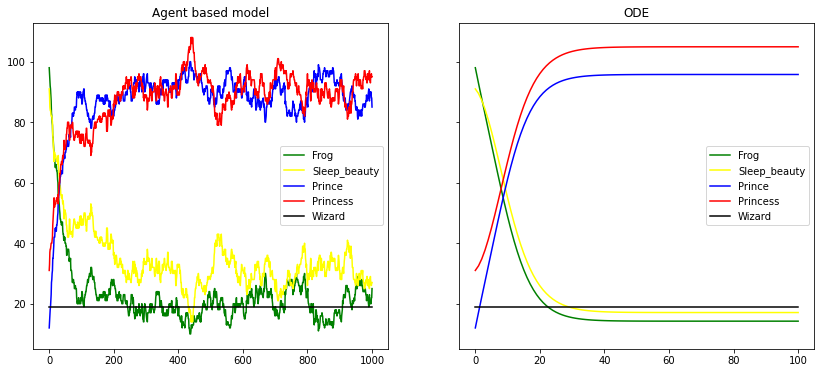

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(14,6),sharey = True)
Agent.model_per(axs[0])
axs[0].legend()
ODE.model_plot(axs[1])
axs[1].legend()
